In [7]:
import pandas as pd
df = pd.read_csv('/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')
print(df.columns)

Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)


In [9]:
# Load CSV
df = pd.read_csv('/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

X = df.drop(columns=['label']).to_numpy().astype(np.float32)  
y = df['encoded_label'].values

print("Feature shape:", X.shape)  

Feature shape: (2132, 2549)


In [12]:
import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
sns.set_style('dark')

2025-07-08 05:05:54.807018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751951155.233898      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751951155.330827      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/tmp/ipykernel_36/977612932.py:8: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'

In [13]:
df = pd.read_csv('../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [14]:
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)

Classes are almost balanced. We can get away with the difference.
label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='label'>

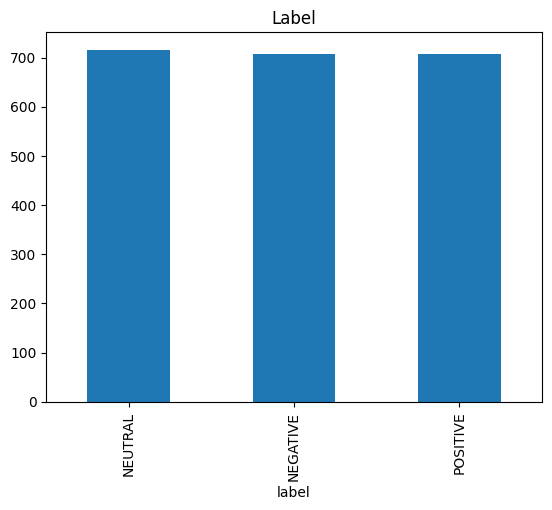

In [15]:
%matplotlib inline
print(f'Classes are almost balanced. We can get away with the difference.\n{df.label.value_counts()}')
df.label.value_counts().plot(kind='bar', color='tab:blue', title='Label')

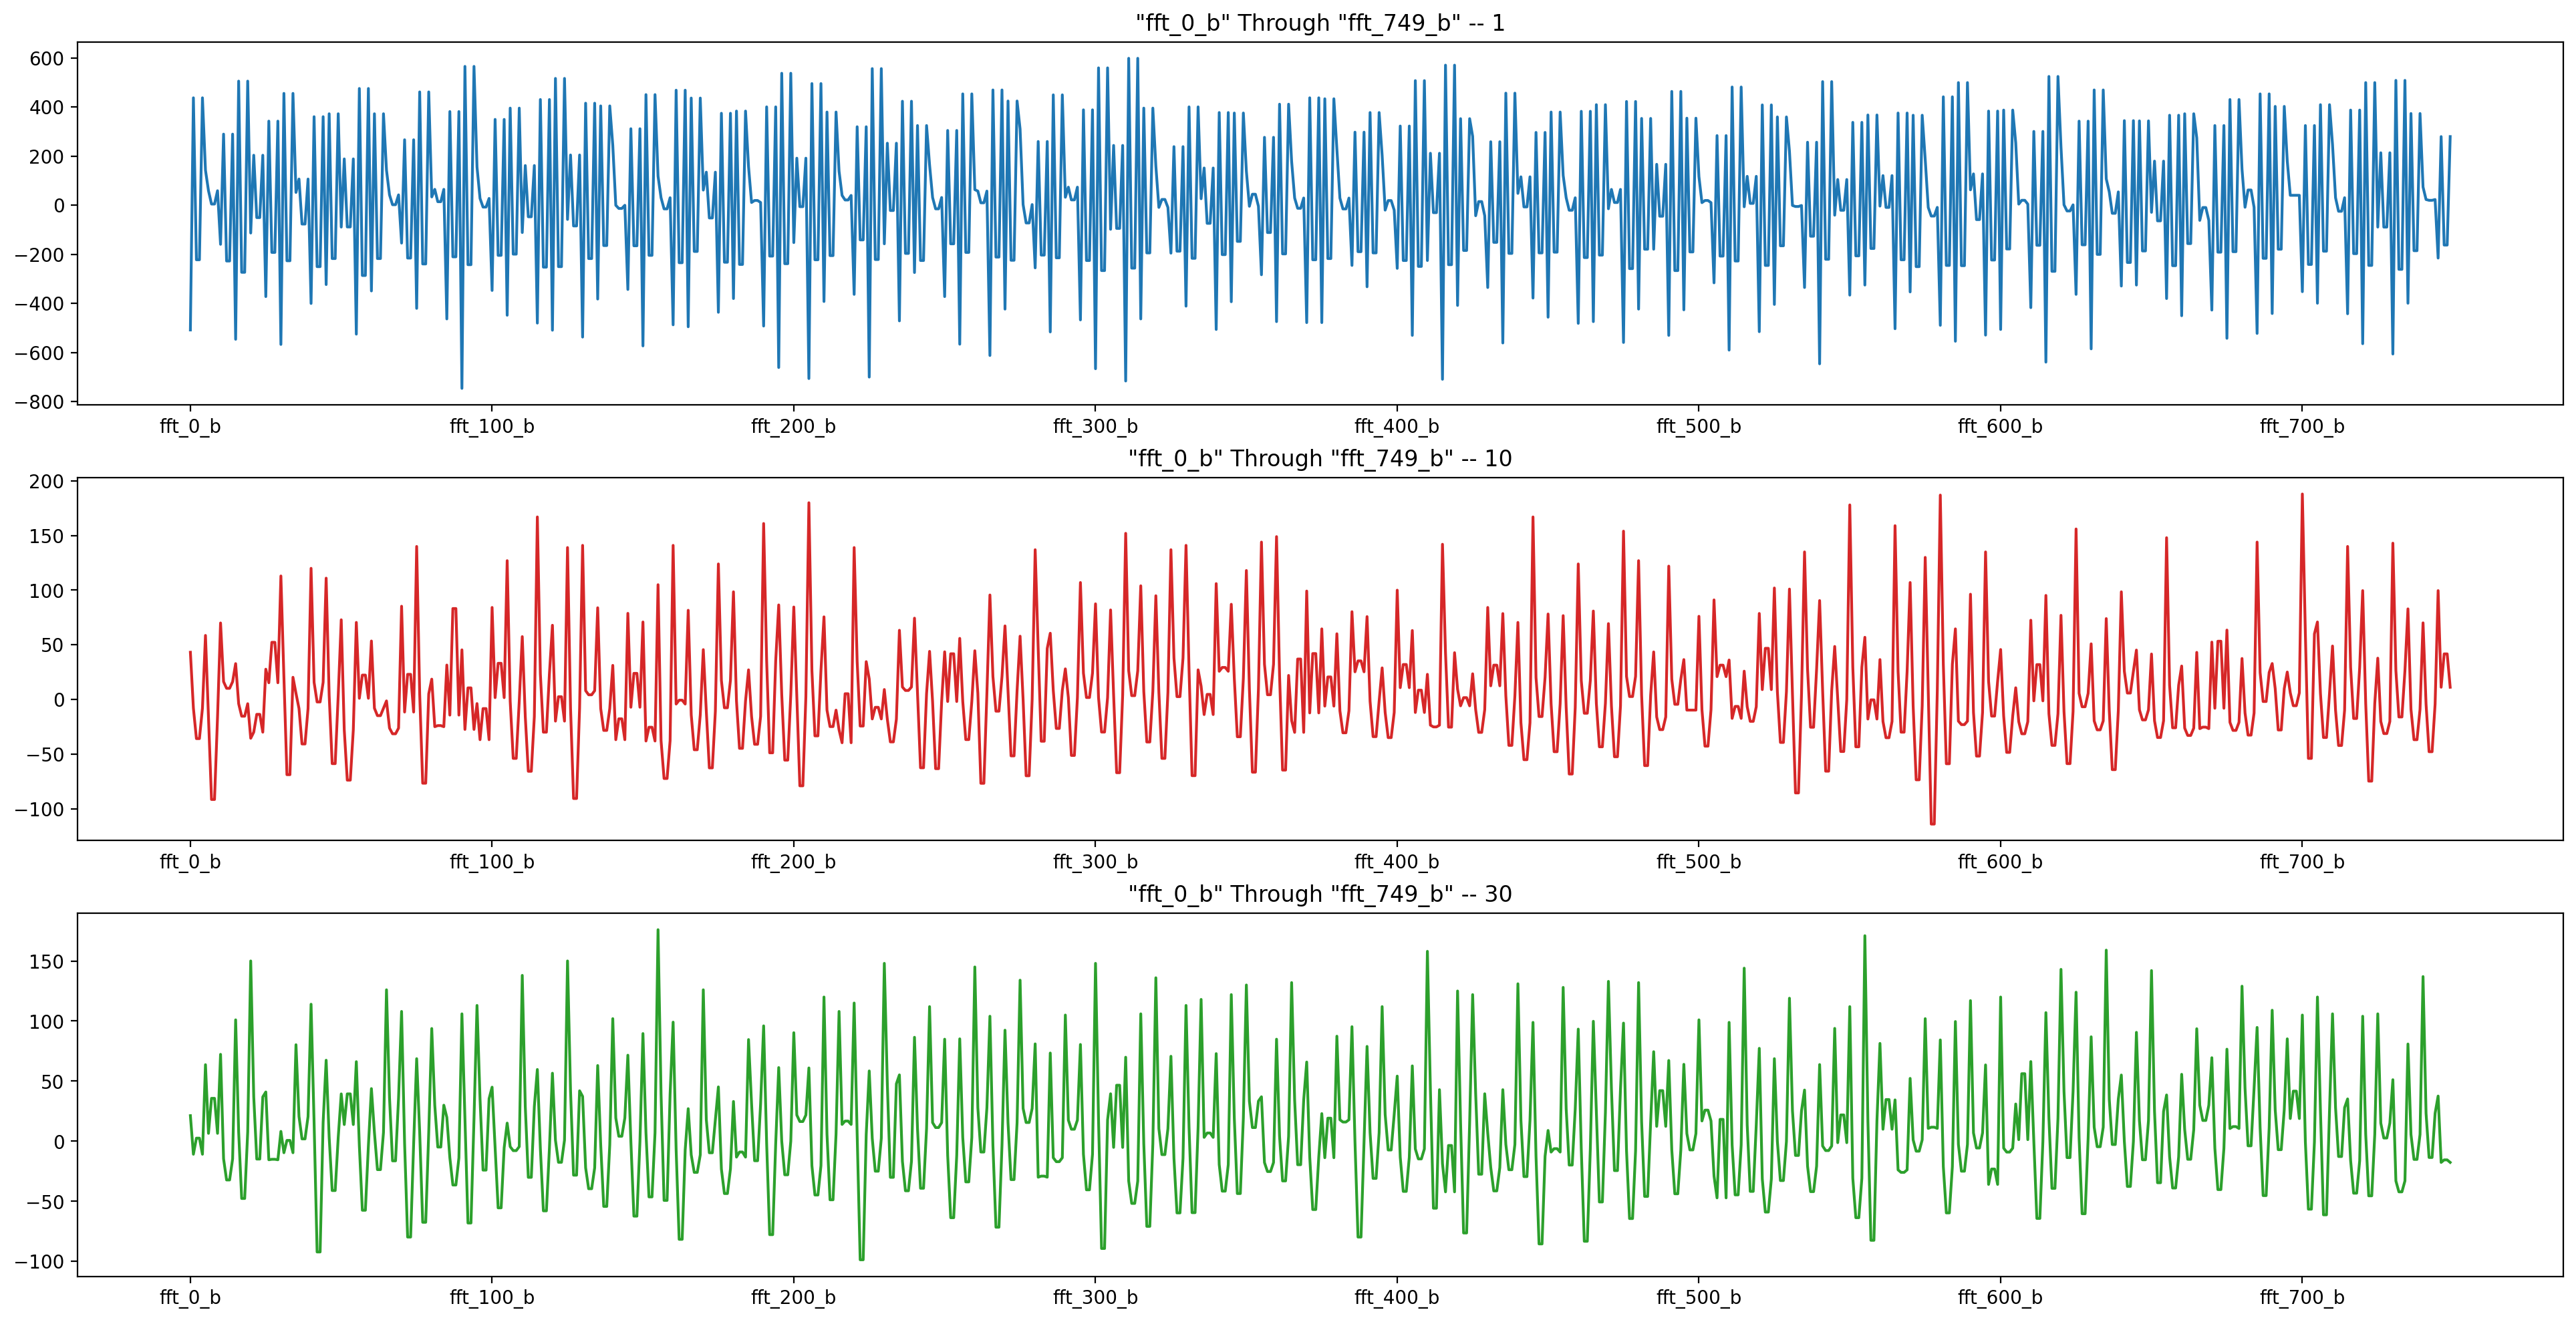

<Figure size 1200x3600 with 0 Axes>

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))
plt.figure(figsize = (12, 36))
df.loc[0, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 1', color='tab:blue', ax=axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.4, hspace=0.4)

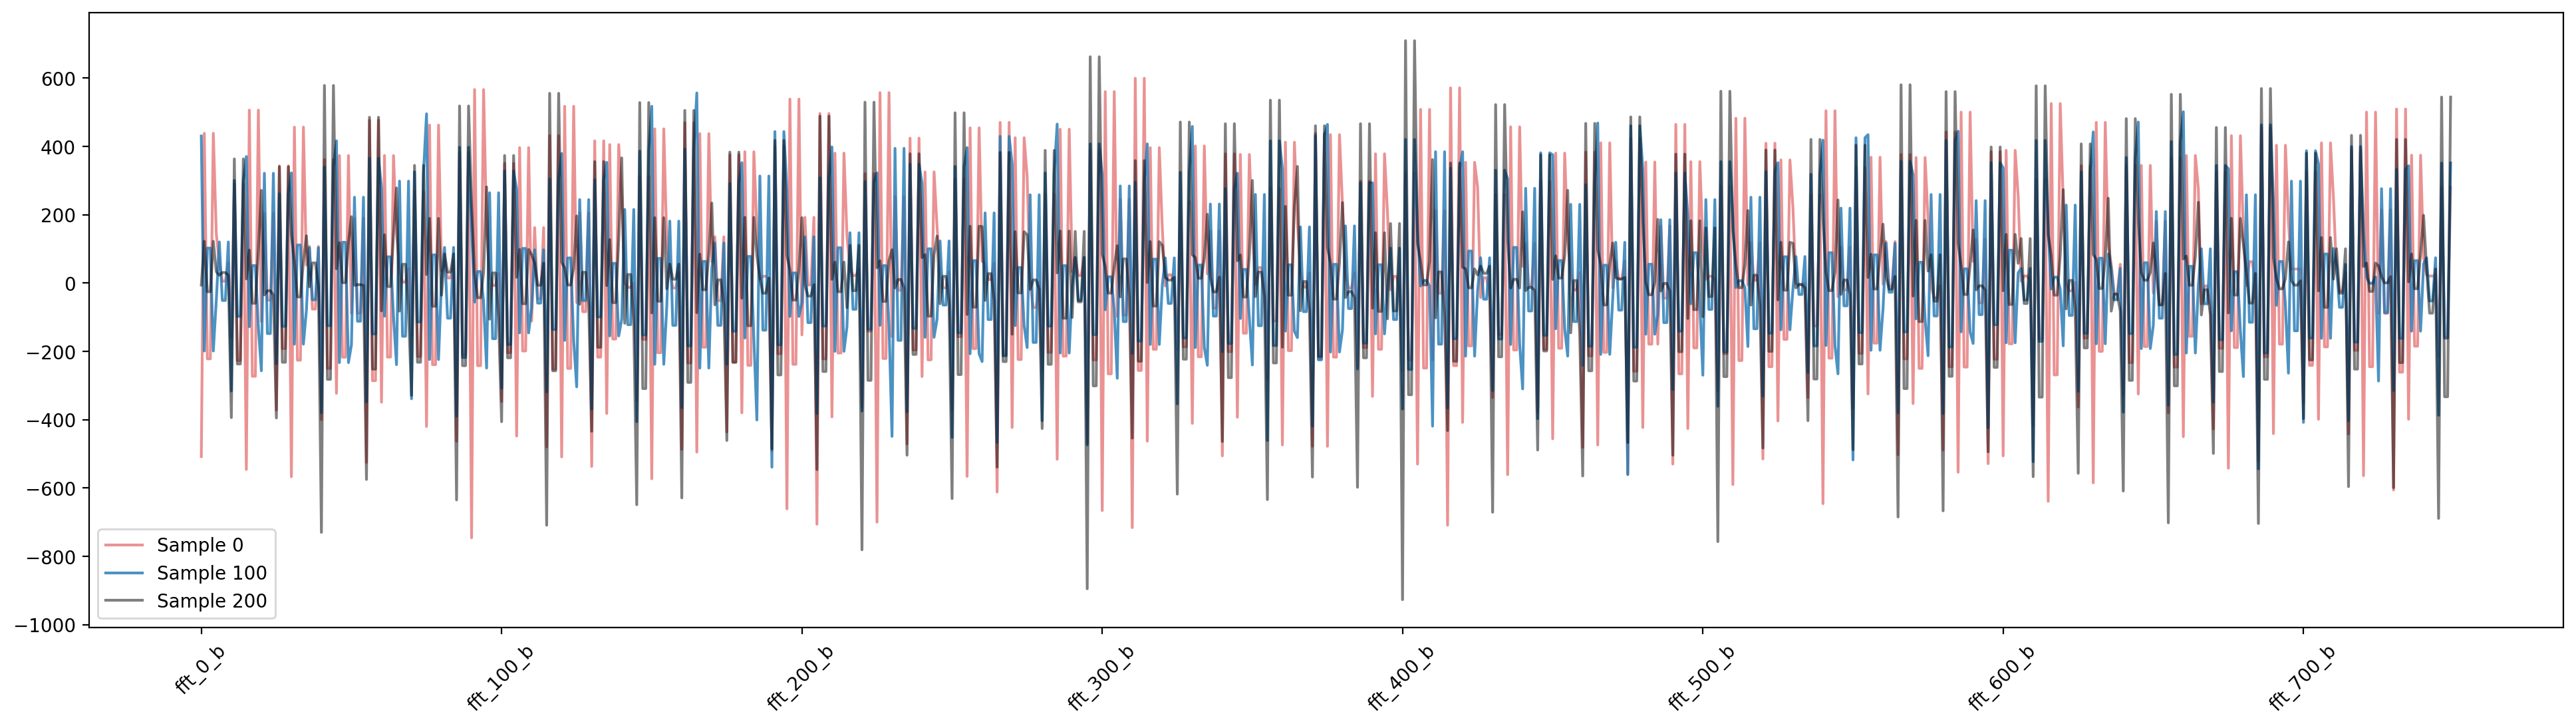

In [17]:
plt.figure(dpi=200, figsize=(24, 6))


plt.plot(df.loc[0, 'fft_0_b':'fft_749_b'], label='Sample 0', color='tab:red', alpha=.5)
plt.plot(df.loc[100, 'fft_0_b':'fft_749_b'], label='Sample 100', color='tab:blue', alpha=.8)
plt.plot(df.loc[200, 'fft_0_b':'fft_749_b'], label='Sample 200', color='black', alpha=.5)


plt.xticks(np.arange(0, len(df.loc[0, 'fft_0_b':'fft_749_b']) + 1, 100), rotation=45)
plt.legend(loc='best')

plt.show()

In [18]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,1
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,2
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,1


In [19]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [20]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

In [23]:
pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 93.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import sklearn
import scikeras
print("scikit-learn version:", sklearn.__version__)
print("scikeras version:", scikeras.__version__)


scikit-learn version: 1.2.2
scikeras version: 0.13.0


In [29]:
!pip install -U scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [31]:
import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from scikeras.wrappers import KerasClassifier  

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

In [32]:
i_lstm = Input(shape=(X_train.shape[1], 1))

x_lstm = LSTM(256, return_sequences=True)(i_lstm)
x_lstm = Flatten()(x_lstm)
y_lstm = Dense(3, activation='softmax')(x_lstm)

model_lstm = Model(i_lstm, y_lstm)

model_lstm.summary()

I0000 00:00:1751951808.960216      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751951808.960955      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2548, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 2548, 256)      │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 652288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │     1,956,867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221,059 (8.47 MB)

 Trainable params: 2,221,059 (8.47 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
                                    
model_lstm.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
lstm_h = model_lstm.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50


I0000 00:00:1751951846.237744     147 cuda_dnn.cc:529] Loaded cuDNN version 90300


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6834 - loss: 18.0111
Epoch 1: val_accuracy improved from -inf to 0.88616, saving model to ./best_lstm_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.6872 - loss: 17.8013 - val_accuracy: 0.8862 - val_loss: 12.6349 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9106 - loss: 6.0841
Epoch 2: val_accuracy improved from 0.88616 to 0.92188, saving model to ./best_lstm_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9109 - loss: 6.0168 - val_accuracy: 0.9219 - val_loss: 2.0296 - learning_rate: 9.0484e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9703 - loss: 0.5125
Epoch 3: val_accuracy improved from 0.92188 to 0.95982, saving model to ./best_lstm_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9706 - loss: 0.5058 - val_accuracy: 0.9598 - val_loss: 0.8860 - learning_rate: 8.1873e-04
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10

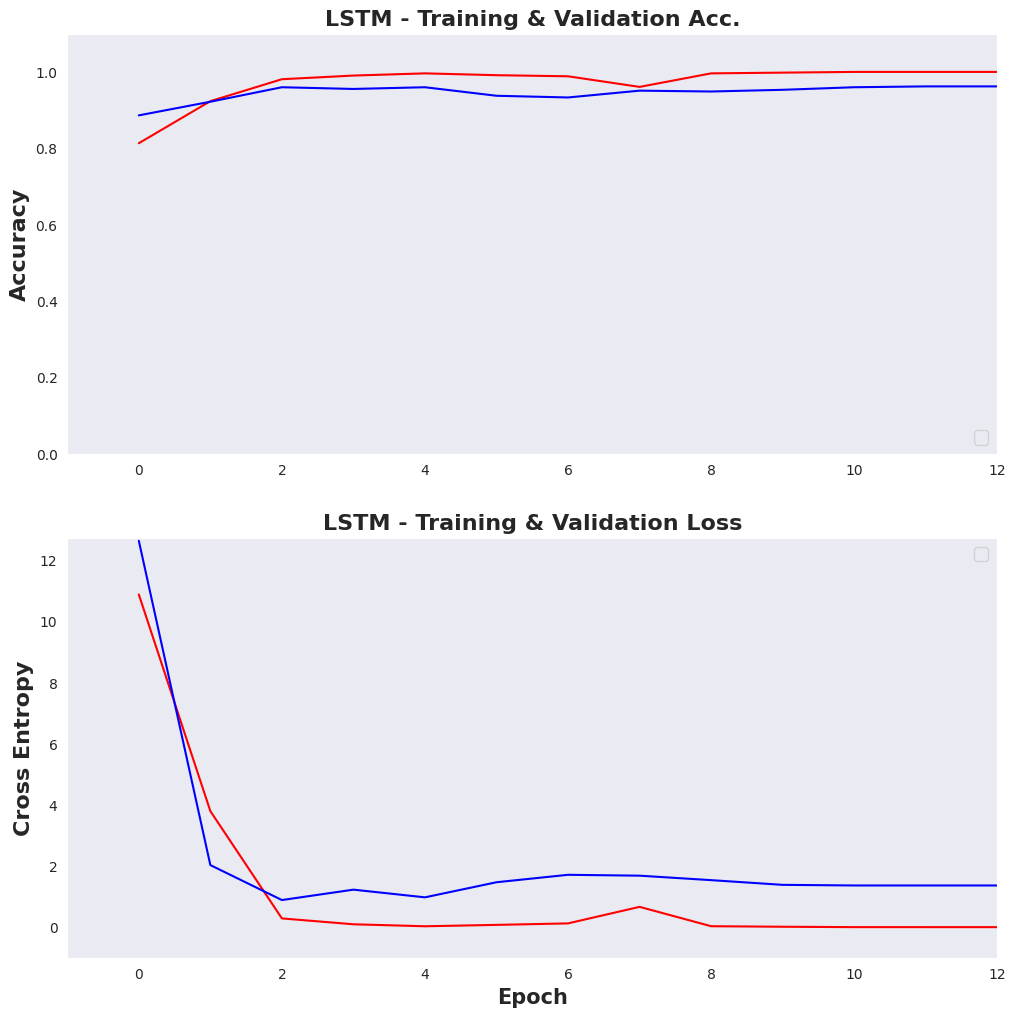

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example history data (replace with your actual LSTM history)
acc = lstm_h.history['accuracy']
val_acc = lstm_h.history['val_accuracy']
loss = lstm_h.history['loss']
val_loss = lstm_h.history['val_loss']

epochs = np.arange(len(acc))  # Number of epochs

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Set up subplots for Accuracy
ax1.set_xlim(-1, len(epochs) - 1)
ax1.set_ylim(0, 1.1)  # Assuming accuracy values are between 0 and 1
ax1.set_title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')
ax1.set_ylabel('Accuracy', fontsize=16, weight='bold')
ax1.legend(loc='lower right', fontsize=13)

# Set up subplots for Loss
ax2.set_xlim(-1, len(epochs) - 1)
ax2.set_ylim(-1, max(max(loss), max(val_loss)) + 0.1)
ax2.set_title('LSTM - Training & Validation Loss', fontsize=16, weight='bold')
ax2.set_ylabel('Cross Entropy', fontsize=16, weight='bold')
ax2.set_xlabel('Epoch', fontsize=15, weight='bold')
ax2.legend(loc='upper right', fontsize=13)

# Create line objects for each plot
train_acc_line, = ax1.plot([], [], label='Training Accuracy', color='r')
val_acc_line, = ax1.plot([], [], label='Validation Accuracy', color='b')
train_loss_line, = ax2.plot([], [], label='Training Loss', color='r')
val_loss_line, = ax2.plot([], [], label='Validation Loss', color='b')

# Initialize function to set the data for each line
def init():
    train_acc_line.set_data([], [])
    val_acc_line.set_data([], [])
    train_loss_line.set_data([], [])
    val_loss_line.set_data([], [])
    return train_acc_line, val_acc_line, train_loss_line, val_loss_line

# Update function for each frame (epoch)
def update(epoch):
    x = epochs[:epoch + 1]
    
    train_acc_line.set_data(x, acc[:epoch + 1])
    val_acc_line.set_data(x, val_acc[:epoch + 1])
    train_loss_line.set_data(x, loss[:epoch + 1])
    val_loss_line.set_data(x, val_loss[:epoch + 1])
    
    return train_acc_line, val_acc_line, train_loss_line, val_loss_line

# Create the animation
ani = FuncAnimation(fig, update, frames=len(epochs), init_func=init, blit=True, repeat=False)

# Save the animation as a video (MP4)
ani.save('lstm_acc_loss_animation.mp4', writer='ffmpeg')

# Alternatively, to display in a Jupyter Notebook:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [35]:
lstm_best = load_model('./best_lstm_model.h5')
lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
print("Test Acc.: {:.3f}%".format(lstm_acc * 100))

Test Acc.: 96.875%


In [36]:
lstm_acc_train = lstm_best.evaluate(X_train, Y_train, verbose=0)[1]
print("Train Acc.: {:.3f}%".format(lstm_acc_train * 100))

Train Acc.: 100.000%


In [38]:
y_pred = np.array(list(map(lambda x: np.argmax(x), lstm_best.predict(x_test))))
cm = confusion_matrix(y_test.idxmax(axis=1), y_pred)
print(classification_report(y_test.idxmax(axis=1), y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       190
           1       1.00      0.97      0.98       231
           2       0.95      0.96      0.95       219

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



Normalized confusion matrix


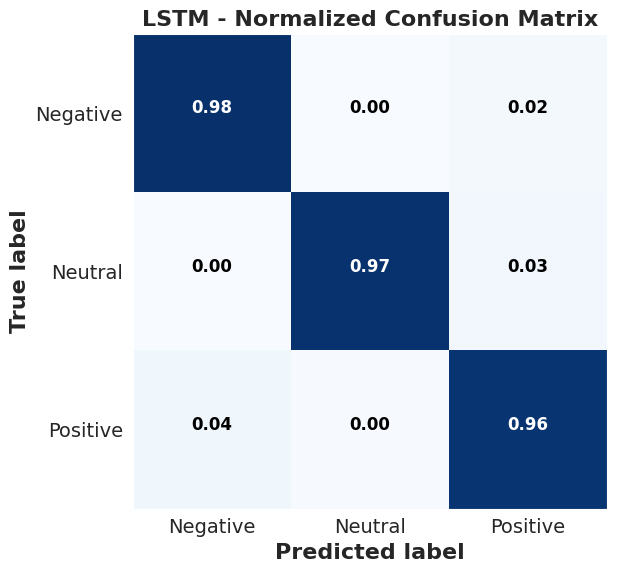

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='LSTM - Normalized Confusion Matrix')
plt.show()